In [47]:
%matplotlib inline

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(0)

In [91]:
FTRAIN = './Data/FKD_Train.csv'
FTEST = './Data/FKD_Test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

#     print(df.count())  # prints the number of values for each column
#     df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values)  #/ 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
#         y = (y - 48) / 48  # scale target coordinates to [-1, 1]
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None

    return X, y, np.array(df.columns[:-1])

X, y, y_name = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))


X.shape == (7049, 9216); X.min == 0.000; X.max == 255.000
y.shape == (7049, 30); y.min == nan; y.max == nan


In [201]:
X_group, y_group = {}, {}
i = 0
for x,f in zip(X,y):    
    picker = ~np.isnan(f)
    id = str.join(',', y_name[picker])
    if id not in X_group:
        X_group[id] = []
        y_group[id] = []
    X_group[id].append(x)
    y_group[id].append(f[picker])
    
g_size = [np.array(y_group[x]).shape[0] for x in X_group.keys()]
big_group = np.argsort(g_size)
print '1st group sample & keypoint: %s' %str(np.array(y_group.items()[big_group[-1]][1]).shape)
print '2nd group sample & keypoint: %s' %str(np.array(y_group.items()[big_group[-2]][1]).shape)


1st group sample & keypoint: (4755, 8)
2nd group sample & keypoint: (2140, 30)


In [4]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

net1.fit(X, y)

  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 100)         	produces     100 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.15368       0.06058      2.53657  0.22s
      2       0.02479       0.01744      1.42206  0.21s
      3       0.01497       0.01531      0.97791  0.21s
      4       0.01299       0.01397      0.93023  0.21s
      5       0.01212       0.01335      0.90781  0.20s
      6       0.01155       0.01283      0.90031  0.24s
      7       0.01109       0.01240      0.89431  0.23s
      8       0.01070       0.01201      0.89124  0.23s
      9       0.01037       0.01166      0.88946  0.24s
     10       0.01008       0.01135      0.88835  0.24s
     11       0.00982       0.01107      0.88785  0.23s
     12       0.00959       0.01080      0.88773  0.25s
     13       0.0

/Users/leiyang/src/lasagne/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


NeuralNet(X_tensor_type=<function matrix at 0x10930c848>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10a1d6350>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10a171610>,
     custom_score=None, eval_size=0.2, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x109e32668>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x10d196758>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x109e32d70>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbose=1,
     y

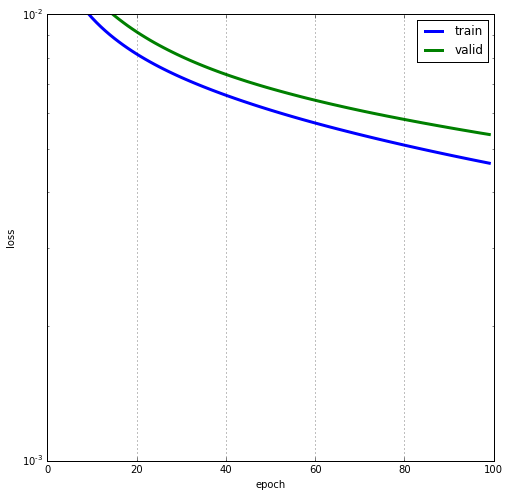

In [8]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
# print train_loss
plt.figure(figsize=(8, 8))
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

ImageId    1783
Image      1783
dtype: int64


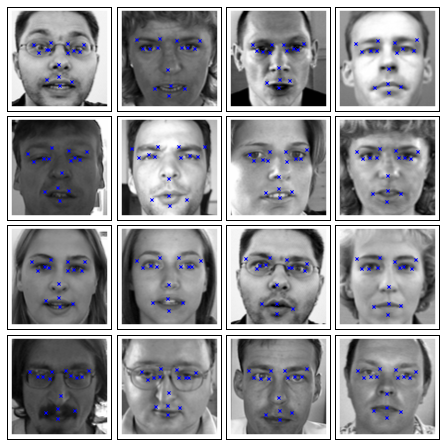

In [7]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load(test=True)
y_pred = net1.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

# plt.show()

In [9]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [ ]:
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,
    
    regression=True,
    max_epochs=100,
    verbose=1,
    )

X, y = load2d()  # load 2-d data
net2.fit(X, y)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b